In [1]:
from glob import glob
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from src.models import *
from src.losses import *
from src.dataset import *
from matplotlib import pyplot as plt

In [2]:
dataset = get_dataset(
    sorted(glob('../DIV2K_train_HR/*')),
    sorted(glob('../DIV2K_train_LR_bicubic/X4/*')),
    128, 16
)
dataset

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 64, 64, 3)), types: (tf.float32, tf.float32)>

In [3]:
y_batch, x_batch = next(iter(dataset))
x_batch = x_batch.numpy()
y_batch = y_batch.numpy()
x_batch.shape, y_batch.shape

((16, 64, 64, 3), (16, 256, 256, 3))

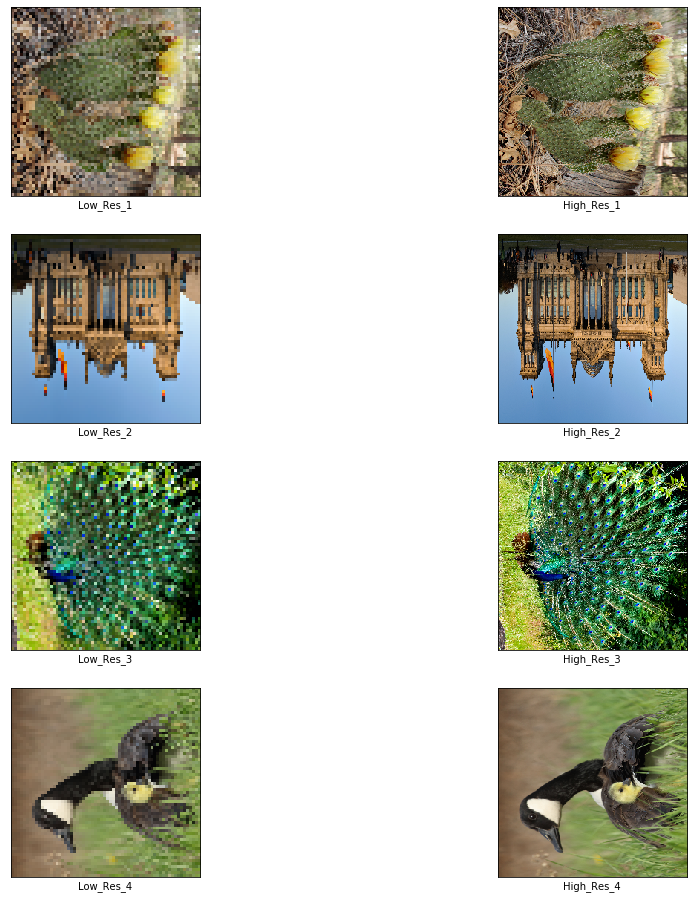

In [4]:
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (16, 16))
plt.setp(axes.flat, xticks = [], yticks = [])
c = 0
for i, ax in enumerate(axes.flat):
    if i % 2 == 0:
        ax.imshow(x_batch[c] / 255.0)
        ax.set_xlabel('Low_Res_' + str(c + 1))
    elif i % 2 == 1:
        ax.imshow(y_batch[c] / 255.0)
        ax.set_xlabel('High_Res_' + str(c + 1))
        c += 1
plt.show()

In [5]:
generator = Generator(LR_SHAPE + [3])
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 64, 64, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   15616       lambda[0][0]                     
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 64, 64, 64)   64          conv2d[0][0]                     
____________________________________________________________________________________________

In [6]:
discriminator = Discriminator(HR_SHAPE + [3])
discriminator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_33 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 64)      0   

In [7]:
sample_hr_batch, sample_lr_batch = next(iter(dataset))
sample_generator_output = generator(sample_lr_batch)
sample_discriminator_output_true = discriminator(sample_hr_batch)
sample_discriminator_output_fake = discriminator(sample_generator_output)
print('Sample High Res Batch Shape: {}'.format(sample_hr_batch.shape))
print('Sample Low Res Batch Shape: {}'.format(sample_lr_batch.shape))
print('Sample Generator Output Shape: {}'.format(sample_generator_output.shape))
print('Sample Discriminator Output Shape on Real Data: {}'.format(sample_discriminator_output_true.shape))
print('Sample Discriminator Output Shape on Fake Data: {}'.format(sample_discriminator_output_fake.shape))

Sample High Res Batch Shape: (16, 256, 256, 3)
Sample Low Res Batch Shape: (16, 64, 64, 3)
Sample Generator Output Shape: (16, 256, 256, 3)
Sample Discriminator Output Shape on Real Data: (16, 1)
Sample Discriminator Output Shape on Fake Data: (16, 1)


In [8]:
learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[100000],
    values=[1e-4, 1e-5]
)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [9]:
@tf.function
def train_step(lr, hr):
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        lr = tf.cast(lr, tf.float32)
        hr = tf.cast(hr, tf.float32)
        sr = generator(lr, training=True)
        hr_output = discriminator(hr, training=True)
        sr_output = discriminator(sr, training=True)
        c_loss = content_loss(hr, sr)
        g_loss = generator_loss(sr_output)
        p_loss = c_loss + 0.001 * g_loss
        d_loss = discriminator_loss(hr_output, sr_output)
    g_gradients = g_tape.gradient(p_loss, generator.trainable_variables)
    d_gradients = g_tape.gradient(d_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(
        g_gradients,
        generator.trainable_variables
    ))
    discriminator_optimizer.apply_gradients(zip(
        d_gradients,
        discriminator.trainable_variables
    ))
    return c_loss, g_loss, p_loss, d_loss

In [10]:
def train(dataset, steps=200000):
    c_loss_hist, g_loss_hist, p_loss_hist, d_loss_hist = [], [], [], []
    s = 0
    for lr, hr in tqdm(dataset.take(steps)):
        s += 1
        c_loss, g_loss, p_loss, d_loss = train_step(lr, hr)
        c_loss_hist.append(c_loss)
        g_loss_hist.append(g_loss)
        p_loss_hist.append(p_loss)
        d_loss_hist.append(d_loss)
        if loss % 100 == 0:
            print(
                '{} Steps -> Perceptual Loss: {}\tDiscriminator Loss: {}'.format(
                    s, p_loss_hist[-1], d_loss_hist[-1]
                )
            )

In [11]:
train(dataset)

0it [00:04, ?it/s]


ValueError: in converted code:

    <ipython-input-9-8fec3a9507b3>:7 train_step  *
        hr_output = discriminator(hr, training=True)
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/engine/base_layer.py:847 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/engine/network.py:708 call
        convert_kwargs_to_constants=base_layer_utils.call_context().saving)
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/engine/network.py:860 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/engine/base_layer.py:812 __call__
        self.name)
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/engine/input_spec.py:213 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer dense is incompatible with the layer: expected axis -1 of input shape to have value 131072 but received input with shape [16, 8192]
